In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, recall_score
from sklearn.impute import SimpleImputer


In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print("Initial shape:", df.shape)
df.head()


Initial shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Duplicate rows found: 0


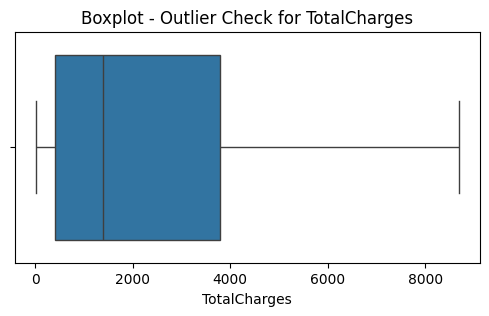

In [3]:
duplicates = df.duplicated().sum()
print(f"Duplicate rows found: {duplicates}")
df = df.drop_duplicates()
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
plt.figure(figsize=(6, 3))
sns.boxplot(x=df["TotalCharges"])
plt.title("Boxplot - Outlier Check for TotalCharges")
plt.show()
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})


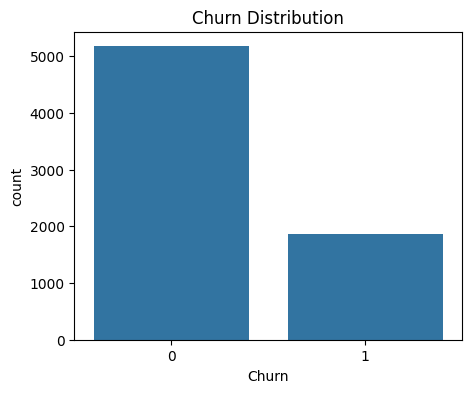

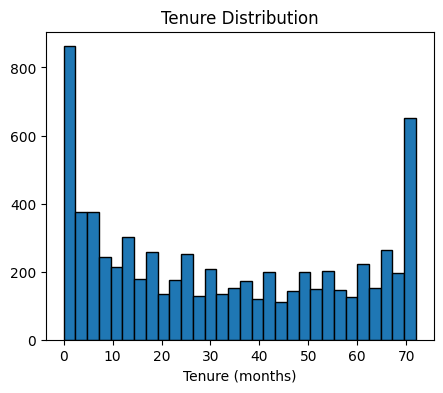

In [4]:
plt.figure(figsize=(5, 4))
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.show()
plt.figure(figsize=(5, 4))
plt.hist(df["tenure"], bins=30, edgecolor="black")
plt.title("Tenure Distribution")
plt.xlabel("Tenure (months)")
plt.show()


In [5]:
X = df.drop(columns=["Churn"])
y = df["Churn"]
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (5634, 19)
Test shape: (1409, 19)


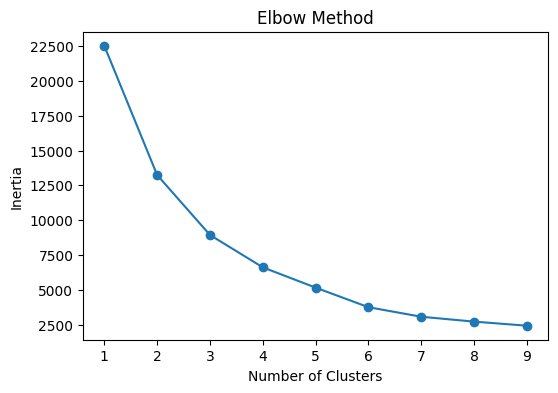

Cluster feature created.
Updated Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'cluster']


In [7]:
km_imputer = SimpleImputer(strategy='median')
scaler_km = StandardScaler()
X_train_num = km_imputer.fit_transform(X_train[numeric_features])
X_train_scaled = scaler_km.fit_transform(X_train_num)
X_test_num = km_imputer.transform(X_test[numeric_features])
X_test_scaled = scaler_km.transform(X_test_num)
inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans_test = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans_test.fit(X_train_scaled)
    inertia.append(kmeans_test.inertia_)
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
X_train = X_train.copy()
X_test = X_test.copy()
X_train["cluster"] = kmeans.fit_predict(X_train_scaled)
X_test["cluster"] = kmeans.predict(X_test_scaled)
X_train["cluster"] = X_train["cluster"].astype(str)
X_test["cluster"] = X_test["cluster"].astype(str)
categorical_features_with_cluster = categorical_features + ["cluster"]
print("Cluster feature created.")
print("Updated Categorical features:", categorical_features_with_cluster)


In [8]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(drop="first", handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features_with_cluster),
    ]
)


In [9]:
results = []
def evaluate_model(model, name, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred)
    recall = recall_score(y_te, y_pred)
    print(f"--- {name} ---")
    print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | Recall: {recall:.4f}")
    return {"Model": name, "Accuracy": acc, "F1-Score": f1}
pipe_lr = Pipeline([("preprocess", preprocessor), ("clf", LogisticRegression(max_iter=1000))])
results.append(evaluate_model(pipe_lr, "LogReg (Baseline)", X_train, y_train, X_test, y_test))
pipe_knn = Pipeline([("preprocess", preprocessor), ("clf", KNeighborsClassifier(n_neighbors=5))])
results.append(evaluate_model(pipe_knn, "KNN", X_train, y_train, X_test, y_test))
pipe_rf = Pipeline([("preprocess", preprocessor), ("clf", RandomForestClassifier(random_state=42))])
results.append(evaluate_model(pipe_rf, "RandomForest (Baseline)", X_train, y_train, X_test, y_test))


--- LogReg (Baseline) ---
Accuracy: 0.8041 | F1: 0.6023 | Recall: 0.5588
--- KNN ---
Accuracy: 0.7637 | F1: 0.5530 | Recall: 0.5508
--- RandomForest (Baseline) ---
Accuracy: 0.7835 | F1: 0.5455 | Recall: 0.4893


--- LogReg (Tuned) ---
Accuracy: 0.8048 | F1: 0.6032 | Recall: 0.5588


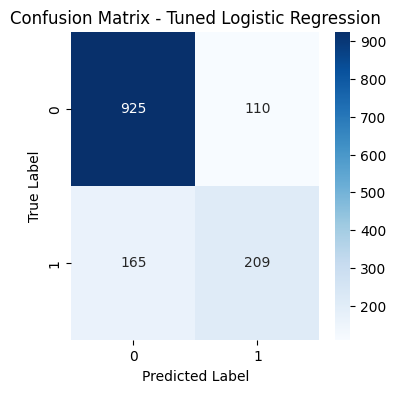


--- Business Impact Analysis ---
False Negatives (Missed Churners): 165
Average Monthly Charge: $64.76
Estimated Monthly Revenue at Risk: $10685.68


In [10]:
param_grid_lr = {'clf__C': [0.1, 1.0, 10.0]}
grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
results.append(evaluate_model(grid_lr, "LogReg (Tuned)", X_train, y_train, X_test, y_test))
best_lr = grid_lr.best_estimator_
y_pred_best_lr = best_lr.predict(X_test)
cm_lr = confusion_matrix(y_test, y_pred_best_lr)
plt.figure(figsize=(4, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Tuned Logistic Regression")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()
false_negatives = cm_lr[1, 0]
avg_monthly_charge = df['MonthlyCharges'].mean()
revenue_risk = false_negatives * avg_monthly_charge
print(f"\n--- Business Impact Analysis ---")
print(f"False Negatives (Missed Churners): {false_negatives}")
print(f"Average Monthly Charge: ${avg_monthly_charge:.2f}")
print(f"Estimated Monthly Revenue at Risk: ${revenue_risk:.2f}")


In [11]:
param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, None]
}
grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
results.append(evaluate_model(grid_rf, "RandomForest (Tuned)", X_train, y_train, X_test, y_test))
best_rf = grid_rf.best_estimator_


--- RandomForest (Tuned) ---
Accuracy: 0.8034 | F1: 0.5847 | Recall: 0.5214


In [12]:
try:
    feature_names = best_lr.named_steps["preprocess"].get_feature_names_out()
    coefs = best_lr.named_steps["clf"].coef_[0]
    coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefs})
    print("Top 5 indicators of Churn (Positive Coefs):")
    print(coef_df.sort_values(by="Coefficient", ascending=False).head())
    print("\nTop 5 indicators of Retention (Negative Coefs):")
    print(coef_df.sort_values(by="Coefficient", ascending=True).head())
except Exception as e:
    print(f"Could not extract coefficients: {e}")


Top 5 indicators of Churn (Positive Coefs):
                             Feature  Coefficient
10  cat__InternetService_Fiber optic     2.348654
23          cat__StreamingMovies_Yes     0.840774
21              cat__StreamingTV_Yes     0.835579
9             cat__MultipleLines_Yes     0.595261
3                  num__TotalCharges     0.505525

Top 5 indicators of Retention (Negative Coefs):
                                Feature  Coefficient
2                   num__MonthlyCharges    -1.874471
8   cat__MultipleLines_No phone service    -1.384526
25               cat__Contract_Two year    -1.354291
1                           num__tenure    -1.289910
7                 cat__PhoneService_Yes    -0.720654


In [13]:
results_df = pd.DataFrame(results)
print("=" * 60)
print("Summary (Sorted by F1-Score):")
print(results_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True))


Summary (Sorted by F1-Score):
                     Model  Accuracy  F1-Score
0           LogReg (Tuned)  0.804826  0.603175
1        LogReg (Baseline)  0.804116  0.602305
2     RandomForest (Tuned)  0.803407  0.584708
3                      KNN  0.763662  0.553020
4  RandomForest (Baseline)  0.783534  0.545455
